In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
#%matplotlib inline
#sns.set(style="whitegrid")
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import itertools
import os

In [2]:
def load_uniformity_data(path):
    sig = pd.read_csv(path, sep = ';', header = None)
    sig_t = sig.transpose()
    
    
    #Convert str to numeric
    sig_t.iloc[:,2:] = sig_t.iloc[:,2:].astype(np.float16)
    sig_t.iloc[:,1] = sig_t.iloc[:,1].astype(np.int64)
    sig_t.rename(columns = {0:'level', 1:'plate'}, inplace = True)
    
    #stack data on same level and plate into one column
    data = {}
    for level in ['NC', 'PC', 10, 25]:
        data[level] = {}
        for plate in range(1,5):
            data[level][plate] = list(itertools.chain(*sig_t[(sig_t.level == level) & (sig_t.plate == plate)].iloc[:,2:].values.tolist()))
                                      
    df = pd.DataFrame.from_dict(data, orient="index").stack().to_frame()                                      
    # to break out the lists into columns
    df = pd.DataFrame(df[0].values.tolist(), index=df.index)
    df = df.transpose()
                                      
    return df

In [3]:
def drop_outliers(df, level, plate):
    median, percent_25, percent_75 = calculate_stats(df[level][plate].dropna().values)
    #sns.distplot(median)
    #sns.distplot(percent_25)
    #sns.distplot(percent_75)
    
    IQR = np.mean(percent_75) - np.mean(percent_25)
    Lb = np.mean(percent_25) - 1.5*IQR
    Ub = np.mean(percent_75) + 1.5*IQR
    #print(level, plate, Lb, Ub)
    
    ind = df[level][plate].loc[(df[level][plate] < Ub) & (df[level][plate] > Lb)].index
    return df[level][plate].loc[ind]

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [5]:
def prepare_df(df):
    clean_dic = {}
    for level in ['NC', 'PC', 10, 25]:
        clean_dic[level] = {}
        for plate in range(1,5):
        ############
            clean_dic[level][plate] = df[level][plate]

            #clean_dic[level][plate] = drop_outliers(df, level, plate)
        ############    
    cleaned_df = pd.DataFrame.from_dict(clean_dic, orient="index").stack().to_frame()
    # to break out the lists into columns
    cleaned_df = pd.DataFrame(cleaned_df[0].values.tolist(), index=cleaned_df.index)
    cleaned_df = cleaned_df.transpose()
    inh_df = cleaned_df.copy()
    
    #Calculate %Inhibition
    controls = inh_df[['NC', 'PC']].mean()
    for level in [10, 25]:
        for plate in range(1,5):
            inh_df['%inh_' + str(level), plate] = 100*(1 - (inh_df[level][plate] - controls['NC'][plate])/(controls['PC'][plate]- controls['NC'][plate]))
    
    return inh_df, cleaned_df

In [6]:
def calculate_stats(data):
    np.random.seed(0)
    median = list(map(np.median, get_bootstrap_samples(data, 1000)))
    percent_25 = list(map(lambda x: np.percentile(x, 25.), get_bootstrap_samples(data, 1000)))
    percent_75 = list(map(lambda x: np.percentile(x, 75.), get_bootstrap_samples(data, 1000)))
    return median, percent_25, percent_75

# Реализация методов обнаружения выбросов

In [950]:
def IQR(df):
    median = np.median(df)
    percent_25 = np.percentile(df, 25.)
    percent_75 = np.percentile(df, 75.)
    IQR = percent_75 - percent_25
    Lb = percent_25 - 1.5*IQR
    Ub = percent_75 + 1.5*IQR
    mask = ((df > Lb) & (df < Ub))
    return mask

In [951]:
example = [1, 2, 3, 3, 4, 4, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 9, 12, 52, 90]
MAD = stats.median_abs_deviation(example, scale = 'normal')
MAD

2.965204437011204

In [954]:
def MAD(df):
    b = 1.4826
    median = np.median(df)
    MAD = b * stats.median_abs_deviation(df)
    rel_MAD = (np.abs(df - median))/MAD
    mask = rel_MAD < 2.5
    return mask

In [955]:
# xi=outlier if the median distance of xi from all other points, is greater than λ times 
# the median absolute distance of every point from every other point:

def Sn(df):
    c = [0, 0.743, 1.851, 0.954, 1.351, 0.993, 1.198, 1.005, 1.131]
    if len(df) < 10:
        correction = c[len(df)]
    elif len(df)//2 ==0:
        correction = n/(n-0.9)
    else:
        correction = 1
            
    df = df.to_list()
    all_dist = []
    ind_point_dist = []
    for el in range(0, len(df)):
        point_dist = []
        for other in df[el+1:-1]:
            dist = np.abs(df[el] - other)
            point_dist.append(dist)
            all_dist.append(dist)
        for other in df[0:el+1]:
            dist = np.abs(df[el] - other)
            point_dist.append(dist)
        
        ind_point_dist.append(point_dist)
        
    Sn = correction* stats.median_abs_deviation(all_dist)
    
    ind_point_median = []
    
    for k in ind_point_dist:
        ind_point_median.append(np.median(k))
        
        
    return ind_point_median/Sn < 3.25

# Загрузка данных по однородности планшетов

In [956]:
from os import listdir
from os.path import isfile, join
mypath = '~/odnorodnost/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['odnorodnost_090621_Ilona.csv',
 'odnorodnost_020621_Ilona.csv',
 'odnorodnost_260521_BIP.csv',
 'odnorodnost_090621_BIP.csv']

In [957]:
df_pers_dic  = {}
df_dic = {}
for file in onlyfiles:
    if file != 'odnorodnost_020621_Ilona.csv':
        df_pers_dic[file], df_dic[file]  = prepare_df(load_uniformity_data(join(mypath, file)))  

# Обработка данных по сигналу на каждом планшете

In [958]:
df_sig = pd.concat({k: pd.DataFrame(v) for k, v in df_dic.items()}, axis=0)
df_sig

NC                                \
                                        1         2         3         4   
odnorodnost_090621_Ilona.csv 0   0.126099  0.140015  0.134155  0.240601   
                             1   0.139282  0.179565  0.139404  0.193359   
                             2   0.137817  0.135376  0.137085  0.221191   
                             3   0.131470  0.150635  0.156494  0.274658   
                             4   0.135620  0.184204  0.170410  0.245850   
                             5   0.146362  0.222778  0.211304  0.234375   
                             6   0.128052  0.232666  0.304199  0.251953   
                             7   0.135742  0.192627  0.353760  0.216309   
                             8   0.147583  0.173584  0.147583  0.195068   
                             9   0.156128  0.146729  0.170898  0.193848   
                             10  0.153320  0.176636  0.206665  0.225586   
                             11  0.149536  0.190552  0.208984  0.184937   
                             12  0.159180       NaN       NaN  0.208618   
                             13  0.142822       NaN       NaN  0.216919   
                             14  0.172974       NaN       NaN  0.184570   
                             15  0.140625       NaN       NaN  0.182983   
                             16  0.167725       NaN       NaN  0.237549   
                             17  0.179810       NaN       NaN  0.182861   
odnorodnost_260521_BIP.csv   0        NaN  0.160034  0.140015  0.180054   
                             1        NaN  0.189941  0.549805  0.160034   
                             2        NaN  0.180054  0.130005  0.170044   
                             3   0.549805  0.109985  1.429688  0.170044   
                             4   0.170044  0.209961  0.379883  0.180054   
                             5   0.170044  0.180054  0.189941  0.189941   
                             6   0.160034  0.140015  0.180054  0.219971   
                             7   0.160034  0.150024  0.160034  0.180054   
                             8   0.180054  0.150024  0.160034  0.189941   
                             9   0.160034  0.170044  0.180054  0.209961   
                             10  0.170044  0.170044  0.180054  0.219971   
                             11  0.150024  0.150024  0.180054  0.180054   
                             12  0.649902  0.500000  0.180054  0.170044   
                             13  0.140015  0.140015  0.180054  0.140015   
                             14  0.150024  0.150024  0.170044  0.160034   
odnorodnost_090621_BIP.csv   0        NaN       NaN       NaN  0.103943   
                             1        NaN       NaN       NaN  0.134399   
                             2   0.217896  0.148315  0.170898  0.119995   
                             3        NaN       NaN       NaN  0.129395   
                             4        NaN       NaN       NaN  0.141357   
                             5   0.230835  0.149658  0.128174  0.109802   
                             6        NaN       NaN  0.152832  0.134399   
                             7        NaN       NaN  0.113831  0.122253   
                             8   0.217285  0.148682  0.126831  0.122742   
                             9        NaN       NaN  0.158569  0.136963   
                             10       NaN       NaN  0.140869  0.145630   
                             11  0.184814  0.125244  0.113831  0.112427   
                             12       NaN       NaN       NaN  0.116028   
                             13       NaN       NaN       NaN  0.100525   
                             14  0.273438       NaN       NaN  0.117310   
                             15       NaN       NaN       NaN  0.133179   
                             16       NaN       NaN       NaN  0.136108   
                             17  0.132324       NaN       NaN  0.128174   

                                       PC                      

In [959]:
PC = df_sig[['PC']]
NC = df_sig[['NC']]
sig_10 = df_sig[[10]]
sig_25 = df_sig[[25]]

In [960]:
for df in [PC, NC, sig_25, sig_10]:
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace = True)
    df.rename(columns = {'level_0':'experiment'}, inplace = True)
    df = df.drop(['level_1'], axis = 1, inplace = True)   

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [961]:
sig_10 = sig_10.replace(to_replace = 'odnorodnost_260521_BIP.csv', value = '260521_BIP')
sig_25 = sig_25.replace(to_replace = 'odnorodnost_090621_BIP.csv', value = '090621_BIP')

to_drop_from10 = sig_10[sig_10['experiment'] == '260521_BIP']
to_drop_from25 = sig_25[sig_25['experiment'] == '090621_BIP']

sig_10_corr = pd.concat([sig_10, to_drop_from25], ignore_index = True)
sig_25_corr = pd.concat([sig_25, to_drop_from10], ignore_index = True)

sig_10_corr = sig_10_corr.drop(index = to_drop_from10.index).reset_index().drop('index', axis = 1)
sig_25_corr = sig_25_corr.drop(index = to_drop_from25.index).reset_index().drop('index', axis = 1)

sig_10_corr = sig_10_corr.replace(to_replace = '090621_BIP', value = 'odnorodnost_090621_BIP.csv')
sig_25_corr = sig_25_corr.replace(to_replace = '260521_BIP', value = 'odnorodnost_260521_BIP.csv')

In [962]:
sig_10_corr

,experiment,1,2,3,4
0,odnorodnost_090621_Ilona.csv,0.360107,0.521484,0.625000,0.743652
1,odnorodnost_090621_Ilona.csv,0.333252,0.445557,0.468750,0.708496
2,odnorodnost_090621_Ilona.csv,0.365234,0.540527,0.483643,0.705566
3,odnorodnost_090621_Ilona.csv,0.342773,0.404785,0.481689,0.676758
4,odnorodnost_090621_Ilona.csv,0.358398,0.451416,0.289795,0.666504
5,odnorodnost_090621_Ilona.csv,0.354004,0.439209,0.539062,0.817383
6,odnorodnost_090621_Ilona.csv,0.322021,0.532715,0.516113,0.804688
7,odnorodnost_090621_Ilona.csv,0.312012,0.440918,0.493896,0.652344
8,odnorodnost_090621_Ilona.csv,0.359619,0.502441,0.543457,0.856934
9,odnorodnost_090621_Ilona.csv,0.311768,0.447754,0.534180,0.712891


In [963]:
def calc_outliers(df_melt):
    exps = list(df_melt.experiment.unique())
    for exp in exps:
        for plate in range(1,5):
            df = df_melt[(df_melt.experiment == exp) & (df_melt.plate == plate)]['signal'].dropna()
            ind = df.index
            df_melt.loc[ind,'IQR'] = IQR(df)
            df_melt.loc[ind,'MAD'] = MAD(df)
            df_melt.loc[ind,'Sn'] = Sn(df)
    return(df_melt)


In [964]:
def plot_outliers(df_melt):
    exps = list(df_melt.experiment.unique())

    for exp in exps:
        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
        fig.suptitle(exp)
    
        sns.swarmplot(ax=axes[0], data=df_melt[df_melt.experiment == exp], y='signal', x="plate", hue = 'IQR')
        sns.swarmplot(ax=axes[1], data=df_melt[df_melt.experiment == exp], y='signal', x="plate", hue = 'MAD')
        sns.swarmplot(ax=axes[2], data=df_melt[df_melt.experiment == exp], y='signal', x="plate", hue = 'Sn')
        plt.show()

# PC

In [965]:
#Convert to long form
PC_melt = pd.melt(PC, id_vars = ['experiment'], var_name='plate', value_name='signal')

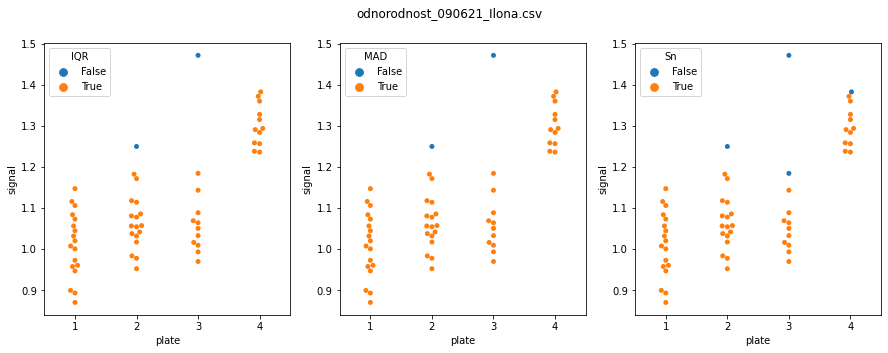

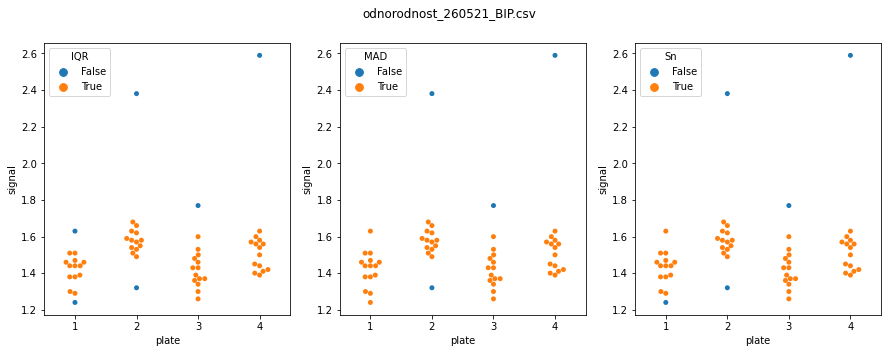

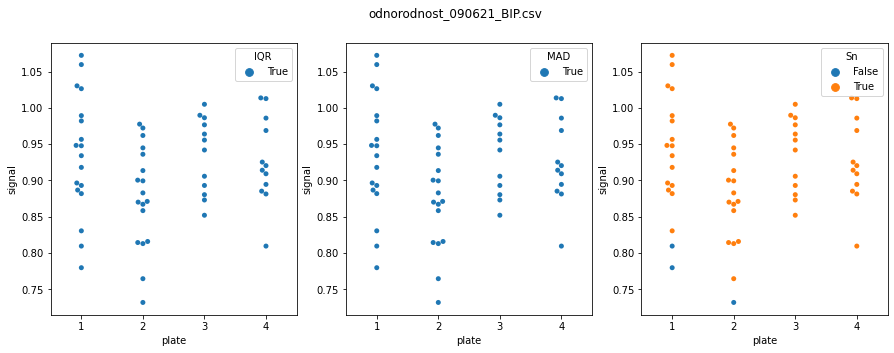

In [966]:
calc_outliers(PC_melt)
plot_outliers(PC_melt)

# NC

In [967]:
NC_melt = pd.melt(NC, id_vars = ['experiment'], var_name='plate', value_name='signal')

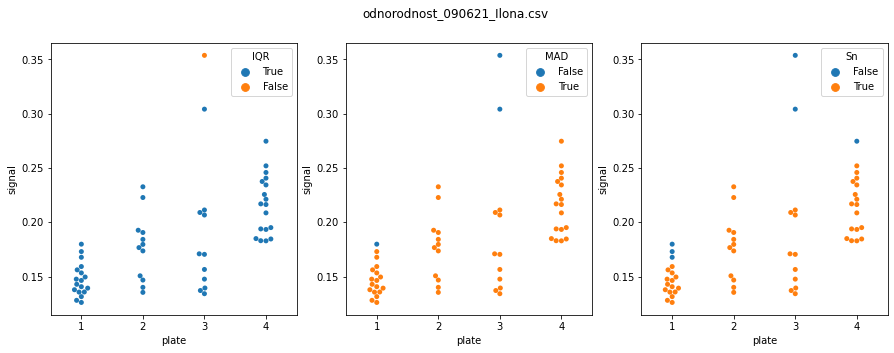

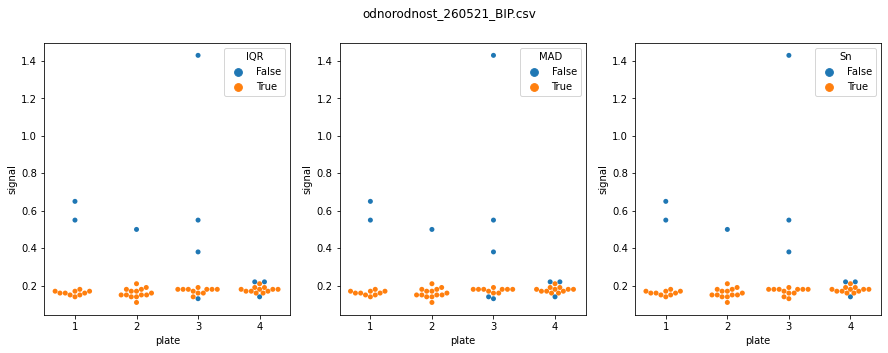

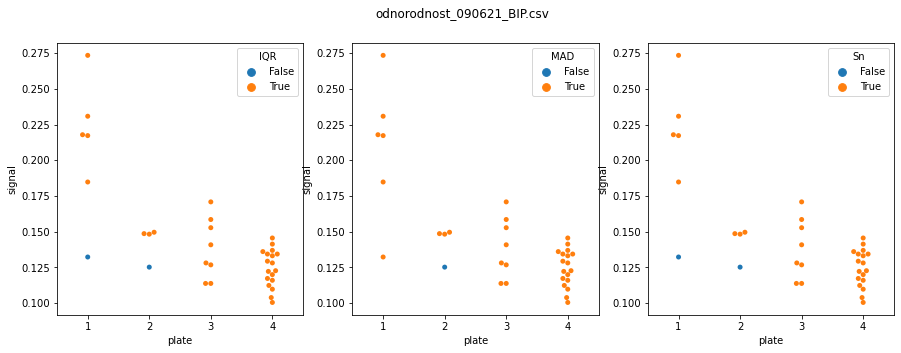

In [968]:
calc_outliers(NC_melt)
plot_outliers(NC_melt)

# Обработка данных по % ингибирования

In [969]:
mean_NC = NC_melt[NC_melt.Sn == True].groupby(['experiment', 'plate'], as_index = False).mean('signal').rename(columns = {'signal':'mean_NC_signal'})
mean_NC

,experiment,plate,mean_NC_signal
0,odnorodnost_090621_BIP.csv,1,0.224854
1,odnorodnost_090621_BIP.csv,2,0.148885
2,odnorodnost_090621_BIP.csv,3,0.138229
3,odnorodnost_090621_BIP.csv,4,0.124702
4,odnorodnost_090621_Ilona.csv,1,0.141976
5,odnorodnost_090621_Ilona.csv,2,0.177114
6,odnorodnost_090621_Ilona.csv,3,0.168298
7,odnorodnost_090621_Ilona.csv,4,0.212740
8,odnorodnost_260521_BIP.csv,1,0.161035
9,odnorodnost_260521_BIP.csv,2,0.160732


In [970]:
mean_PC = PC_melt[PC_melt.Sn == True].groupby(['experiment', 'plate'], as_index = False).mean('signal').rename(columns = {'signal':'mean_PC_signal'})
mean_PC

,experiment,plate,mean_PC_signal
0,odnorodnost_090621_BIP.csv,1,0.953308
1,odnorodnost_090621_BIP.csv,2,0.886087
2,odnorodnost_090621_BIP.csv,3,0.935262
3,odnorodnost_090621_BIP.csv,4,0.926717
4,odnorodnost_090621_Ilona.csv,1,1.010769
5,odnorodnost_090621_Ilona.csv,2,1.061495
6,odnorodnost_090621_Ilona.csv,3,1.044043
7,odnorodnost_090621_Ilona.csv,4,1.294123
8,odnorodnost_260521_BIP.csv,1,1.435686
9,odnorodnost_260521_BIP.csv,2,1.579252


In [971]:
cntr_mean = pd.merge(mean_PC, mean_NC, on=["experiment", "plate"], how="left", sort=False)

In [972]:
cntr_mean

,experiment,plate,mean_PC_signal,mean_NC_signal
0,odnorodnost_090621_BIP.csv,1,0.953308,0.224854
1,odnorodnost_090621_BIP.csv,2,0.886087,0.148885
2,odnorodnost_090621_BIP.csv,3,0.935262,0.138229
3,odnorodnost_090621_BIP.csv,4,0.926717,0.124702
4,odnorodnost_090621_Ilona.csv,1,1.010769,0.141976
5,odnorodnost_090621_Ilona.csv,2,1.061495,0.177114
6,odnorodnost_090621_Ilona.csv,3,1.044043,0.168298
7,odnorodnost_090621_Ilona.csv,4,1.294123,0.212740
8,odnorodnost_260521_BIP.csv,1,1.435686,0.161035
9,odnorodnost_260521_BIP.csv,2,1.579252,0.160732


In [973]:
sig_25_melt = pd.melt(sig_25_corr, id_vars = ['experiment'], var_name='plate', value_name='signal')
sig_10_melt = pd.melt(sig_10_corr, id_vars = ['experiment'], var_name='plate', value_name='signal')

In [974]:
sig_25_melt

,experiment,plate,signal
0,odnorodnost_090621_Ilona.csv,1,0.653320
1,odnorodnost_090621_Ilona.csv,1,0.694824
2,odnorodnost_090621_Ilona.csv,1,0.752930
3,odnorodnost_090621_Ilona.csv,1,0.636230
4,odnorodnost_090621_Ilona.csv,1,0.660645
...,...,...,...
187,odnorodnost_260521_BIP.csv,4,1.160156
188,odnorodnost_260521_BIP.csv,4,1.110352
189,odnorodnost_260521_BIP.csv,4,1.099609
190,odnorodnost_260521_BIP.csv,4,1.099609


In [975]:
res_10 = pd.merge(sig_10_melt, cntr_mean, on=["experiment", "plate"], how="left", sort=False)
res_10 

,experiment,plate,signal,mean_PC_signal,mean_NC_signal
0,odnorodnost_090621_Ilona.csv,1,0.360107,1.010769,0.141976
1,odnorodnost_090621_Ilona.csv,1,0.333252,1.010769,0.141976
2,odnorodnost_090621_Ilona.csv,1,0.365234,1.010769,0.141976
3,odnorodnost_090621_Ilona.csv,1,0.342773,1.010769,0.141976
4,odnorodnost_090621_Ilona.csv,1,0.358398,1.010769,0.141976
...,...,...,...,...,...
211,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702
212,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702
213,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702
214,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702


In [976]:
res_25 = pd.merge(sig_25_melt, cntr_mean, on=["experiment", "plate"], how="left", sort=False)
res_25

,experiment,plate,signal,mean_PC_signal,mean_NC_signal
0,odnorodnost_090621_Ilona.csv,1,0.653320,1.010769,0.141976
1,odnorodnost_090621_Ilona.csv,1,0.694824,1.010769,0.141976
2,odnorodnost_090621_Ilona.csv,1,0.752930,1.010769,0.141976
3,odnorodnost_090621_Ilona.csv,1,0.636230,1.010769,0.141976
4,odnorodnost_090621_Ilona.csv,1,0.660645,1.010769,0.141976
...,...,...,...,...,...
187,odnorodnost_260521_BIP.csv,4,1.160156,1.503557,0.178355
188,odnorodnost_260521_BIP.csv,4,1.110352,1.503557,0.178355
189,odnorodnost_260521_BIP.csv,4,1.099609,1.503557,0.178355
190,odnorodnost_260521_BIP.csv,4,1.099609,1.503557,0.178355


In [977]:
res_25['inh_25'] = 100 - 100*(res_25.signal - res_25.mean_NC_signal)/(res_25.mean_PC_signal - res_25.mean_NC_signal)

In [978]:
res_10['inh_10'] = 100 - 100*(res_10.signal - res_10.mean_NC_signal)/(res_10.mean_PC_signal - res_10.mean_NC_signal)

In [979]:
res_25

,experiment,plate,signal,mean_PC_signal,mean_NC_signal,inh_25
0,odnorodnost_090621_Ilona.csv,1,0.653320,1.010769,0.141976,41.143153
1,odnorodnost_090621_Ilona.csv,1,0.694824,1.010769,0.141976,36.365964
2,odnorodnost_090621_Ilona.csv,1,0.752930,1.010769,0.141976,29.677899
3,odnorodnost_090621_Ilona.csv,1,0.636230,1.010769,0.141976,43.110231
4,odnorodnost_090621_Ilona.csv,1,0.660645,1.010769,0.141976,40.300120
...,...,...,...,...,...,...
187,odnorodnost_260521_BIP.csv,4,1.160156,1.503557,0.178355,25.913112
188,odnorodnost_260521_BIP.csv,4,1.110352,1.503557,0.178355,29.671382
189,odnorodnost_260521_BIP.csv,4,1.099609,1.503557,0.178355,30.481989
190,odnorodnost_260521_BIP.csv,4,1.099609,1.503557,0.178355,30.481989


# Поиск выбросов в %Inh

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


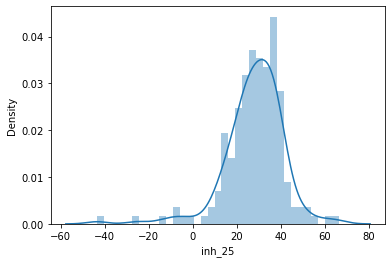

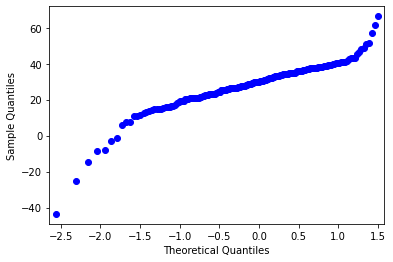

In [1056]:
sns.distplot(res_25.inh_25, 35);
qqplot(np.array(res_25.inh_25), line='s')
pyplot.show();

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


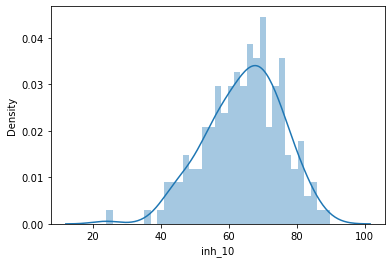

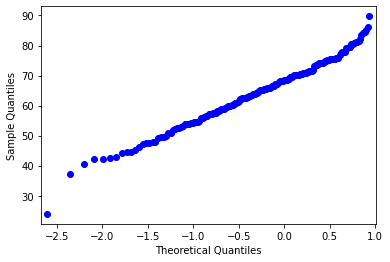

In [1055]:
sns.distplot(res_10.inh_10, 35);
qqplot(np.array(res_10.inh_10), line='s')
pyplot.show()

In [982]:
def calc_outliers(df_melt, inh):
    exps = list(df_melt.experiment.unique())
    for exp in exps:
        for plate in range(1,5):
            df = df_melt[(df_melt.experiment == exp) & (df_melt.plate == plate)][inh].dropna()
            ind = df.index
            df_melt.loc[ind,'IQR'] = IQR(df)
            df_melt.loc[ind,'MAD'] = MAD(df)
            df_melt.loc[ind,'Sn'] = Sn(df)
    return(df_melt)

def plot_outliers(df_melt, inh):
    exps = list(df_melt.experiment.unique())

    for exp in exps:
        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
        fig.suptitle(exp)
    
        sns.swarmplot(ax=axes[0], data=df_melt[df_melt.experiment == exp], y=inh, x="plate", hue = 'IQR')
        sns.swarmplot(ax=axes[1], data=df_melt[df_melt.experiment == exp], y=inh, x="plate", hue = 'MAD')
        sns.swarmplot(ax=axes[2], data=df_melt[df_melt.experiment == exp], y=inh, x="plate", hue = 'Sn')
        plt.show()

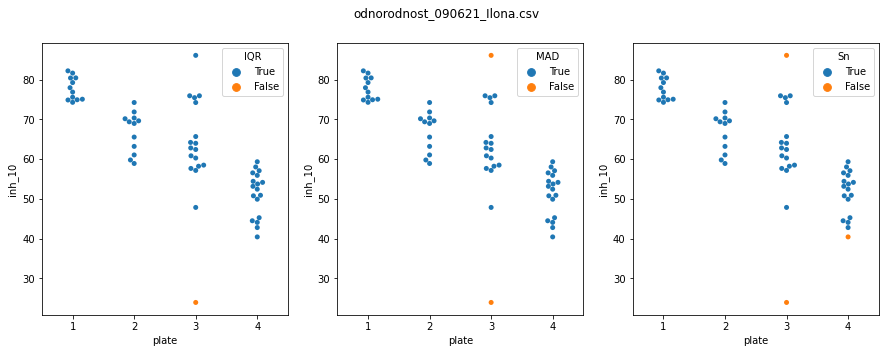

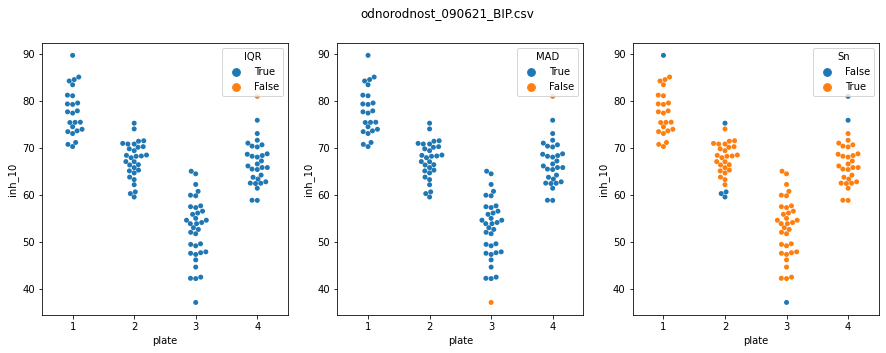

In [983]:
calc_outliers(res_10, 'inh_10')
plot_outliers(res_10, 'inh_10')

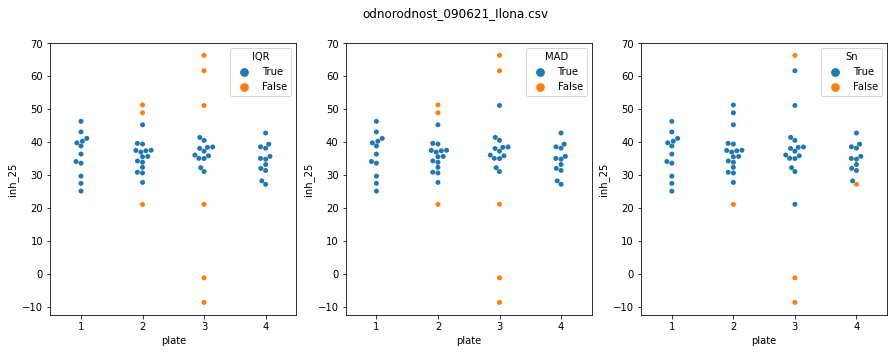

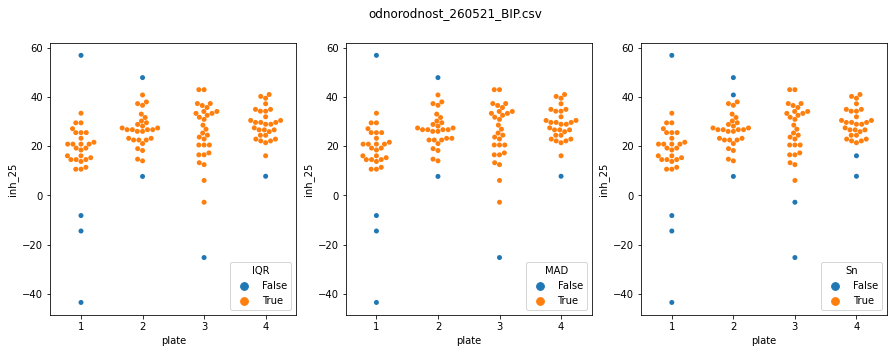

In [984]:
calc_outliers(res_25, 'inh_25')
plot_outliers(res_25, 'inh_25')

In [985]:
def calc_outliers_overall(df_melt, metrics):
    df_melt['distr'] = 1
    df = df_melt[metrics].dropna()
    ind = df.index
    df_melt.loc[ind,'IQR_overall'] = IQR(df)
    df_melt.loc[ind,'MAD_overall'] = MAD(df)
    df_melt.loc[ind,'Sn_overall'] = Sn(df)
    return(df_melt)

def plot_outliers_overall(df_melt, metrics):
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    
    sns.swarmplot(ax=axes[0], data=df_melt, y=metrics, x = 'distr', hue = 'IQR_overall')
    sns.swarmplot(ax=axes[1], data=df_melt, y=metrics, x = 'distr',hue = 'MAD_overall')
    sns.swarmplot(ax=axes[2], data=df_melt, y=metrics, x = 'distr',hue = 'Sn_overall')
    plt.show()

In [986]:
calc_outliers_overall(res_25, 'inh_25')

,experiment,plate,signal,mean_PC_signal,mean_NC_signal,inh_25,IQR,MAD,Sn,distr,IQR_overall,MAD_overall,Sn_overall
0,odnorodnost_090621_Ilona.csv,1,0.653320,1.010769,0.141976,41.143153,True,True,True,1,True,True,True
1,odnorodnost_090621_Ilona.csv,1,0.694824,1.010769,0.141976,36.365964,True,True,True,1,True,True,True
2,odnorodnost_090621_Ilona.csv,1,0.752930,1.010769,0.141976,29.677899,True,True,True,1,True,True,True
3,odnorodnost_090621_Ilona.csv,1,0.636230,1.010769,0.141976,43.110231,True,True,True,1,True,True,True
4,odnorodnost_090621_Ilona.csv,1,0.660645,1.010769,0.141976,40.300120,True,True,True,1,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,odnorodnost_260521_BIP.csv,4,1.160156,1.503557,0.178355,25.913112,True,True,True,1,True,True,True
188,odnorodnost_260521_BIP.csv,4,1.110352,1.503557,0.178355,29.671382,True,True,True,1,True,True,True
189,odnorodnost_260521_BIP.csv,4,1.099609,1.503557,0.178355,30.481989,True,True,True,1,True,True,True
190,odnorodnost_260521_BIP.csv,4,1.099609,1.503557,0.178355,30.481989,True,True,True,1,True,True,True


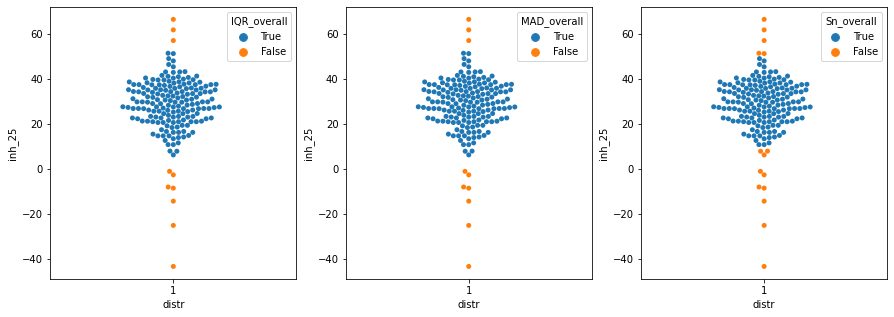

In [987]:
plot_outliers_overall(res_25, 'inh_25')

In [988]:
calc_outliers_overall(res_10, 'inh_10')

,experiment,plate,signal,mean_PC_signal,mean_NC_signal,inh_10,IQR,MAD,Sn,distr,IQR_overall,MAD_overall,Sn_overall
0,odnorodnost_090621_Ilona.csv,1,0.360107,1.010769,0.141976,74.892591,True,True,True,1,True,True,True
1,odnorodnost_090621_Ilona.csv,1,0.333252,1.010769,0.141976,77.983714,True,True,True,1,True,True,True
2,odnorodnost_090621_Ilona.csv,1,0.365234,1.010769,0.141976,74.302468,True,True,True,1,True,True,True
3,odnorodnost_090621_Ilona.csv,1,0.342773,1.010769,0.141976,76.887770,True,True,True,1,True,True,True
4,odnorodnost_090621_Ilona.csv,1,0.358398,1.010769,0.141976,75.089299,True,True,True,1,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
212,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
213,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
214,odnorodnost_090621_BIP.csv,4,NaN,0.926717,0.124702,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


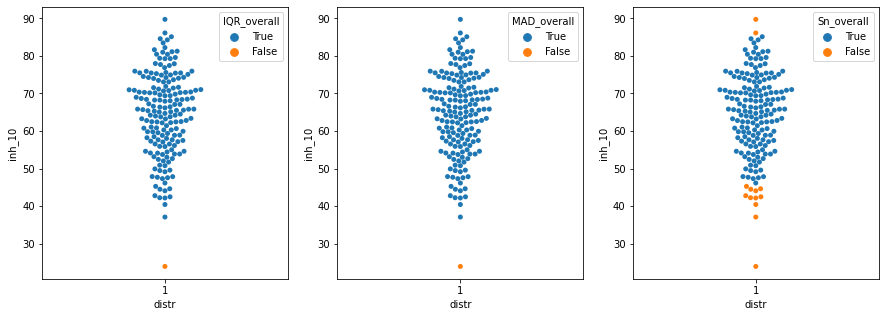

In [989]:
plot_outliers_overall(res_10, 'inh_10')

# Трипликаты

In [990]:
triplets = []
for k in range(0,72):
    for m in range(0,3):
        triplets.append(k)
res_10['triplets'] = triplets

In [991]:
triplets = []
for k in range(0,64):
    for m in range(0,3):
        triplets.append(k)
res_25['triplets'] = triplets

## 10 мкМ

In [992]:
inh_10_Sn = res_10[res_10.Sn_overall == True].groupby('triplets').inh_10.agg(['mean', 'std']).reset_index()
inh_10_Sn['mean'].describe()

count    60.000000
mean     65.076616
std       8.774515
min      49.505115
25%      58.161058
50%      66.275646
75%      70.442487
max      81.633850
Name: mean, dtype: float64

In [993]:
inh_10_MAD = res_10[res_10.MAD_overall == True].groupby('triplets').inh_10.agg(['mean', 'std']).reset_index()
inh_10_MAD['mean'].describe()

count    60.000000
mean     64.590178
std       9.848723
min      43.787292
25%      56.226109
50%      66.471708
75%      70.442487
max      81.633850
Name: mean, dtype: float64

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


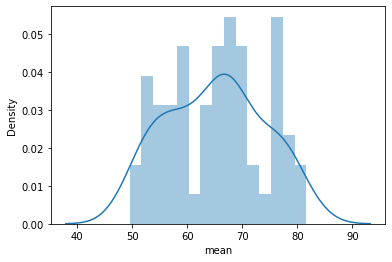

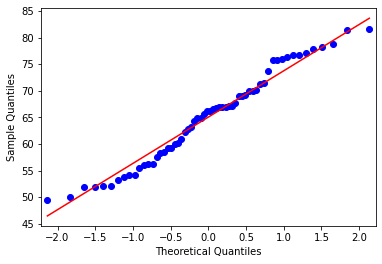

In [1070]:
sns.distplot(inh_10_Sn['mean'], 15);
qqplot(np.array(inh_10_Sn['mean']), line='s');
pyplot.show()

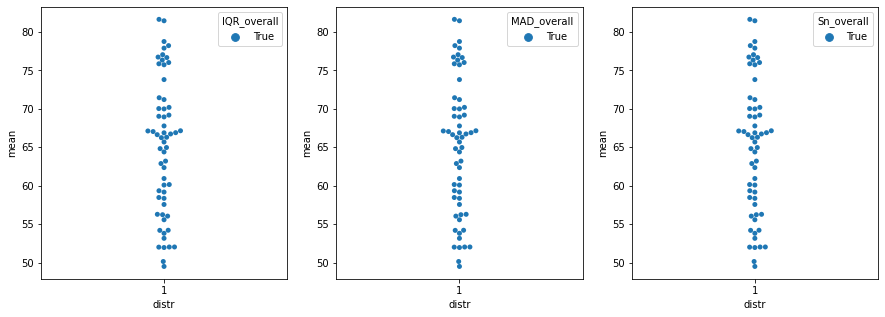

In [995]:
calc_outliers_overall(inh_10_Sn, 'mean')
plot_outliers_overall(inh_10_Sn, 'mean')

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


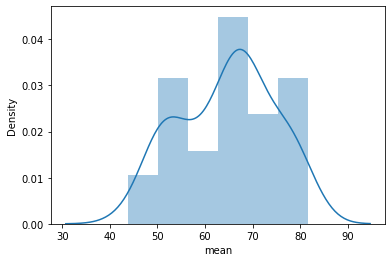

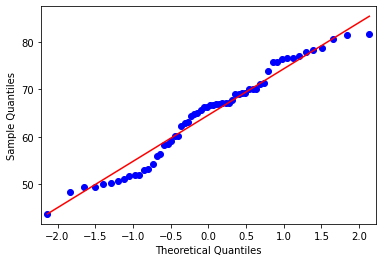

In [996]:
sns.distplot(inh_10_MAD['mean']);
qqplot(np.array(inh_10_MAD['mean']), line='s');
pyplot.show()

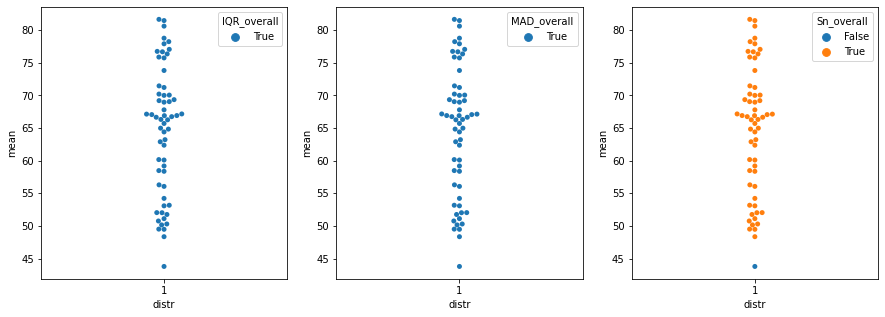

In [997]:
calc_outliers_overall(inh_10_MAD, 'mean')
plot_outliers_overall(inh_10_MAD, 'mean')

## 25 нМ

In [998]:
inh_25_Sn = res_25[res_25.Sn_overall == True].groupby('triplets').inh_25.agg(['mean', 'std']).reset_index()
inh_25_Sn['mean'].describe()

count    60.000000
mean     29.170302
std       6.817093
min      10.660304
25%      24.239529
50%      29.875534
75%      34.393432
max      43.241370
Name: mean, dtype: float64

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


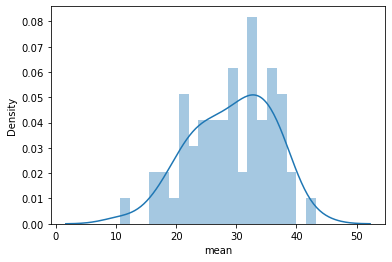

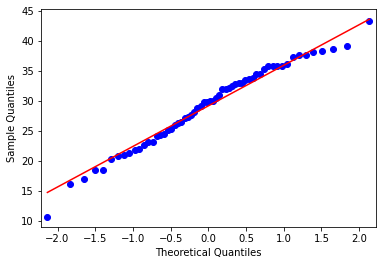

In [1064]:
sns.distplot(inh_25_Sn['mean'], 20);
qqplot(np.array(inh_25_Sn['mean']), line='s');
pyplot.show()

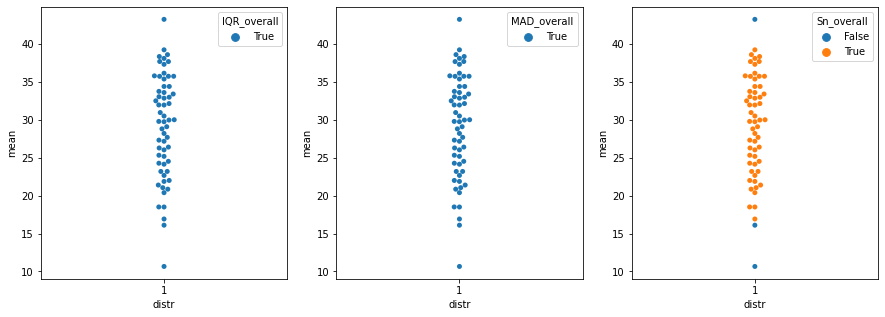

In [1000]:
calc_outliers_overall(inh_25_Sn, 'mean')
plot_outliers_overall(inh_25_Sn, 'mean')

In [1039]:
inh_25_Sn[inh_25_Sn.Sn_overall == True]['mean'].describe()

count    57.000000
mean     29.477483
std       6.013472
min      16.917122
25%      24.520565
50%      29.966148
75%      34.393211
max      39.223578
Name: mean, dtype: float64

In [1001]:
inh_25_MAD = res_25[res_25.MAD_overall == True].groupby('triplets').inh_25.agg(['mean', 'std']).reset_index()
inh_25_MAD['mean'].describe()

count    60.000000
mean     29.052096
std       7.359915
min      10.660304
25%      23.188184
50%      29.875534
75%      34.393432
max      43.241370
Name: mean, dtype: float64

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


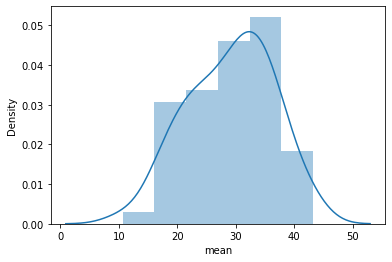

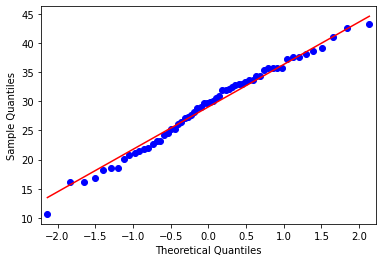

In [1002]:
sns.distplot(inh_25_MAD['mean']);
qqplot(np.array(inh_25_MAD['mean']), line='s');
pyplot.show()

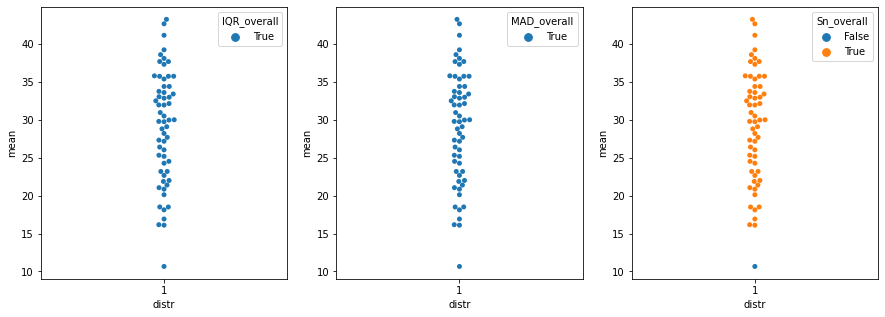

In [1003]:
calc_outliers_overall(inh_25_MAD, 'mean')
plot_outliers_overall(inh_25_MAD, 'mean')

# CV

## Расчет по всему планшету

In [1004]:
inh_10_CV = res_10[res_10.Sn_overall == True].groupby(['experiment', 'plate']).signal.agg(['mean', 'std']).reset_index()
inh_10_CV['CV'] = inh_10_CV['std']/inh_10_CV['mean']*100
inh_10_CV.CV.sort_values()

7     4.489946
1     7.414723
4     7.529280
2     8.152619
0     8.436591
5     9.564620
3     9.962657
6    14.473631
Name: CV, dtype: float64

In [1005]:
inh_25_CV = res_25[res_25.Sn_overall == True].groupby(['experiment', 'plate']).signal.agg(['mean', 'std']).reset_index()
inh_25_CV['CV'] = inh_25_CV['std']/inh_25_CV['mean']*100
inh_25_CV.CV.sort_values()

3     5.425628
2     6.217905
4     6.650751
7     7.271226
1     7.537021
0     8.109269
5     9.034344
6    10.238752
Name: CV, dtype: float64

In [1006]:
inh_10_CV_all = res_10.groupby(['experiment', 'plate']).signal.agg(['mean', 'std']).reset_index()
inh_10_CV_all['CV'] = inh_10_CV_all['std']/inh_10_CV_all['mean']*100
inh_10_CV_all.CV.sort_values()

1     7.414723
4     7.529280
7     8.314524
5     9.564620
0     9.605079
3     9.962657
2    10.224955
6    23.708800
Name: CV, dtype: float64

In [1007]:
NC_CV = NC_melt[NC_melt.Sn == True].groupby(['experiment', 'plate']).signal.agg(['mean', 'std']).reset_index()
NC_CV['CV'] = NC_CV['std']/NC_CV['mean']*100
NC_CV.CV.sort_values()

1      0.466213
4      7.032064
8      7.441780
11     7.852236
3     10.364590
10    10.830316
7     11.251282
0     14.247117
2     15.280044
9     15.519847
5     17.364313
6     18.294009
Name: CV, dtype: float64

In [1008]:
PC_CV = PC_melt[PC_melt.Sn == True].groupby(['experiment', 'plate']).signal.agg(['mean', 'std']).reset_index()
PC_CV['CV'] = PC_CV['std']/PC_CV['mean']*100
PC_CV.CV.sort_values()

7     3.564431
9     3.592039
6     4.847127
11    5.511826
2     5.570970
5     5.899445
8     6.081950
3     6.446780
10    6.556583
1     6.932024
0     7.265876
4     7.905381
Name: CV, dtype: float64

# Рассчет по трипликатам

### 10 мкМ

In [1009]:
len(inh_10_tri_CV)

60

In [1010]:
inh_10_tri_CV = res_10[res_10.Sn_overall == True].groupby('triplets').signal.agg(['mean', 'std']).reset_index()
inh_10_tri_CV['CV'] = inh_10_tri_CV['std']/inh_10_tri_CV['mean']*100
inh_10_tri_CV.CV.sort_values()

29     0.323915
48     0.704590
45     1.079552
25     1.549061
20     1.896545
33     2.209161
1      2.290957
57     2.316515
49     2.499277
40     2.550424
3      2.592655
47     2.884432
44     2.946712
22     3.240257
34     3.251472
37     3.321741
36     3.430988
42     3.846476
28     4.794006
0      4.867985
6      5.329574
13     5.600101
11     6.027990
53     6.193111
15     6.235115
9      6.258776
43     6.268058
4      6.636277
51     7.019076
56     7.061672
17     7.096085
23     7.276285
32     7.328978
52     7.349232
24     7.374381
2      7.578289
55     7.702891
27     7.948821
50     8.390553
58     8.652772
16     9.216898
18     9.299922
59     9.387860
14     9.506953
10     9.623338
12     9.998462
54    10.313943
7     10.821977
21    11.055975
19    11.664939
8     12.652942
5     13.524254
38    13.565045
41    13.637546
30    16.340102
26    16.400602
31    16.560233
39    18.007813
35          NaN
46          NaN
Name: CV, dtype: float64

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


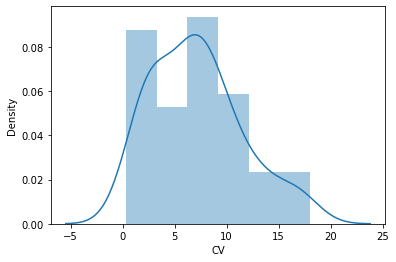

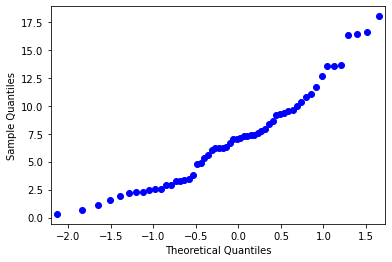

In [1011]:
sns.distplot(inh_10_tri_CV['CV']);
qqplot(np.array(inh_10_tri_CV['CV']), line='s');
pyplot.show()

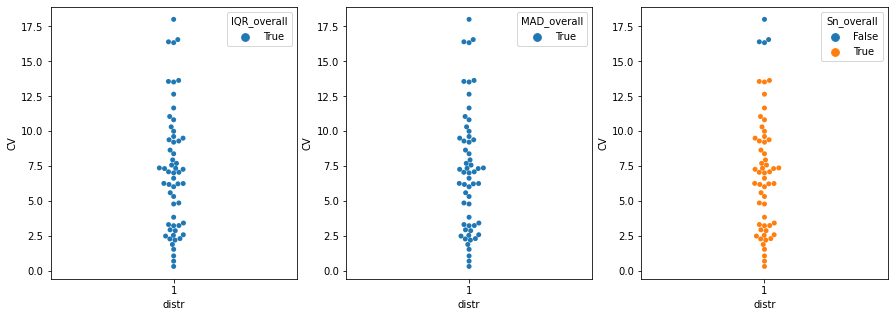

In [1012]:
calc_outliers_overall(inh_10_tri_CV, 'CV')
plot_outliers_overall(inh_10_tri_CV, 'CV')

In [1013]:
inh_10_tri_CV['CV'].median()

7.0403739333991915

### 25 нМ

In [1014]:
inh_25_tri_CV = res_25[res_25.Sn_overall == True].groupby('triplets').signal.agg(['mean', 'std']).reset_index()
inh_25_tri_CV['CV'] = inh_25_tri_CV['std']/inh_25_tri_CV['mean']*100
inh_25_tri_CV.CV.sort_values()


10     0.000000
7      0.000000
59     1.070111
51     1.445785
17     1.843783
30     1.898273
33     2.117951
23     2.163128
34     2.248694
48     2.673042
11     2.785917
47     2.809989
19     2.942177
43     3.067520
14     3.538425
8      3.580811
13     3.694519
24     3.777895
28     3.901565
1      4.116208
20     4.196971
54     4.310651
45     4.380318
5      5.019731
9      5.499055
50     5.499055
55     5.655875
53     5.723099
49     5.882628
2      5.916455
52     6.065551
27     6.279146
6      6.629253
32     7.048958
0      7.144165
38     7.274576
56     7.556610
37     7.822165
44     8.266942
3      8.456440
29     8.855740
15     8.917510
58     9.117009
46     9.212899
40     9.460440
25     9.555007
21     9.849178
12    10.262151
22    10.538837
36    11.174985
16    11.374619
41    11.539317
57    11.726468
4     11.855440
39    12.079354
35    13.666029
18    18.304961
26    18.657277
42    22.336644
31          NaN
Name: CV, dtype: float64

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


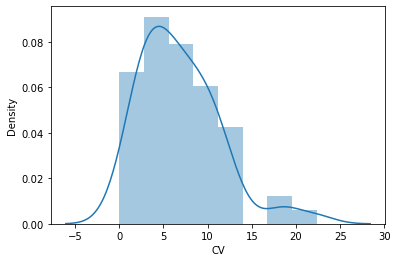

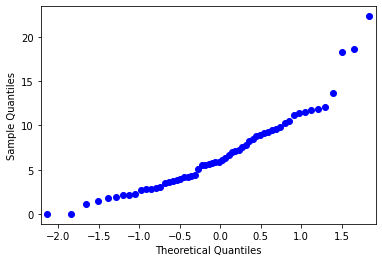

In [1015]:
sns.distplot(inh_25_tri_CV['CV']);
qqplot(np.array(inh_25_tri_CV['CV']), line='s');
pyplot.show()

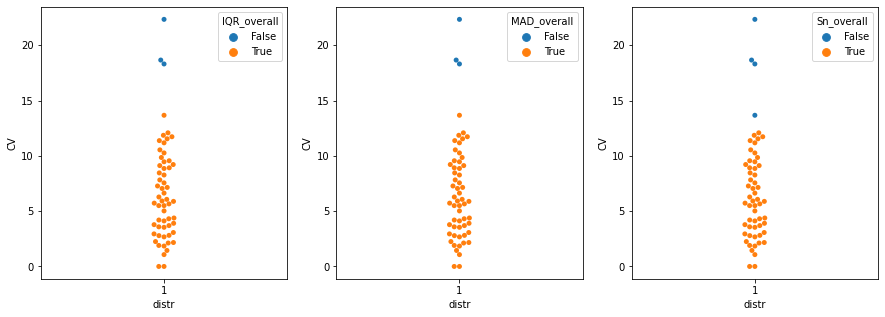

In [1016]:
calc_outliers_overall(inh_25_tri_CV, 'CV')
plot_outliers_overall(inh_25_tri_CV, 'CV')


In [1017]:
inh_25_tri_CV['CV'].median()

5.916455090402752

https://link.springer.com/article/10.3758/s13414-019-01726-3

### PC

In [1018]:
triplets = []
for k in range(0,68):
    for m in range(0,3):
        triplets.append(k)
PC_melt['triplets'] = triplets

In [1019]:
PC_tri_CV = PC_melt[PC_melt.Sn == True].groupby('triplets').signal.agg(['mean', 'std']).reset_index()
PC_tri_CV['CV'] = PC_tri_CV['std']/PC_tri_CV['mean']*100
PC_tri_CV.CV.sort_values()

6      0.498665
16     0.504383
51     0.692521
19     1.294729
49     1.512727
59     1.573046
48     1.700031
26     1.993373
4      2.049373
31     2.090753
3      2.097543
55     2.274387
56     2.399585
10     2.461314
35     2.759607
17     2.839110
47     2.941616
2      3.054928
27     3.074161
54     3.288668
34     3.479026
14     3.531930
58     3.553766
33     3.554384
52     3.717814
24     3.879529
30     4.171205
23     4.343616
46     4.475974
1      4.993865
39     5.026658
36     5.115414
57     5.305549
42     5.400680
50     5.557907
11     5.633706
9      5.697345
29     5.733993
28     5.949566
32     6.118638
8      6.240818
40     6.371339
44     6.373503
20     6.393155
18     6.615077
45     6.621590
13     7.039614
5      7.185433
43     7.577647
22     7.788566
53     8.148118
7      8.222869
38     8.259853
37     8.786724
12     9.238510
41     9.381207
0      9.754456
15    12.720343
21    13.391084
25          NaN
Name: CV, dtype: float64

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


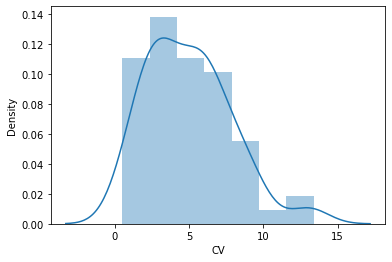

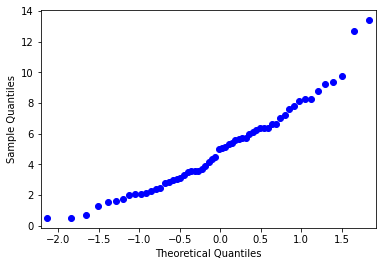

In [1020]:
sns.distplot(PC_tri_CV['CV']);
qqplot(np.array(PC_tri_CV['CV']), line='s');
pyplot.show()

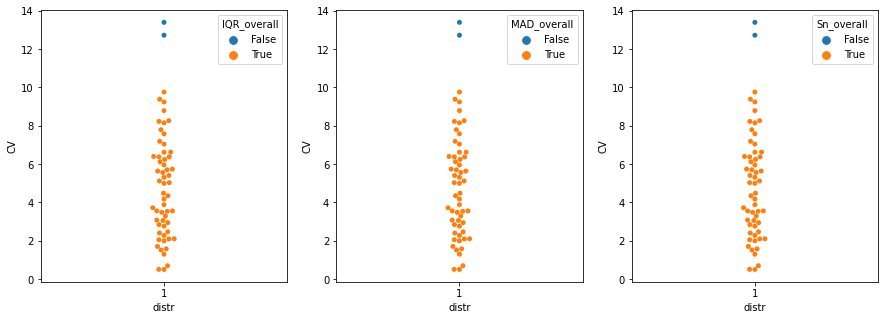

In [1021]:
calc_outliers_overall(PC_tri_CV, 'CV')
plot_outliers_overall(PC_tri_CV, 'CV')

### NC

In [1022]:
NC_melt

,experiment,plate,signal,IQR,MAD,Sn
0,odnorodnost_090621_Ilona.csv,1,0.126099,True,True,True
1,odnorodnost_090621_Ilona.csv,1,0.139282,True,True,True
2,odnorodnost_090621_Ilona.csv,1,0.137817,True,True,True
3,odnorodnost_090621_Ilona.csv,1,0.131470,True,True,True
4,odnorodnost_090621_Ilona.csv,1,0.135620,True,True,True
...,...,...,...,...,...,...
199,odnorodnost_090621_BIP.csv,4,0.100525,True,True,True
200,odnorodnost_090621_BIP.csv,4,0.117310,True,True,True
201,odnorodnost_090621_BIP.csv,4,0.133179,True,True,True
202,odnorodnost_090621_BIP.csv,4,0.136108,True,True,True


In [1023]:
triplets = []
for k in range(0,68):
    for m in range(0,3):
        triplets.append(k)
NC_melt['triplets'] = triplets

NC_tri_CV = NC_melt[NC_melt.Sn == True].groupby('triplets').signal.agg(['mean', 'std']).reset_index()
NC_tri_CV['CV'] = NC_tri_CV['std']/NC_tri_CV['mean']*100


/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


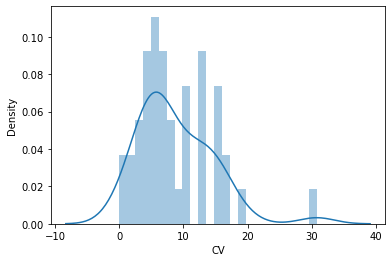

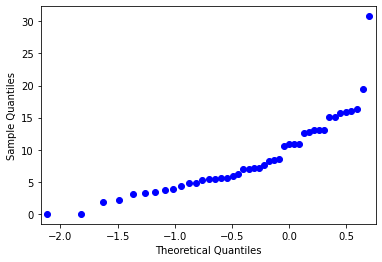

In [1062]:
sns.distplot(NC_tri_CV['CV'],25);
qqplot(np.array(NC_tri_CV['CV']), line='s');
pyplot.show()

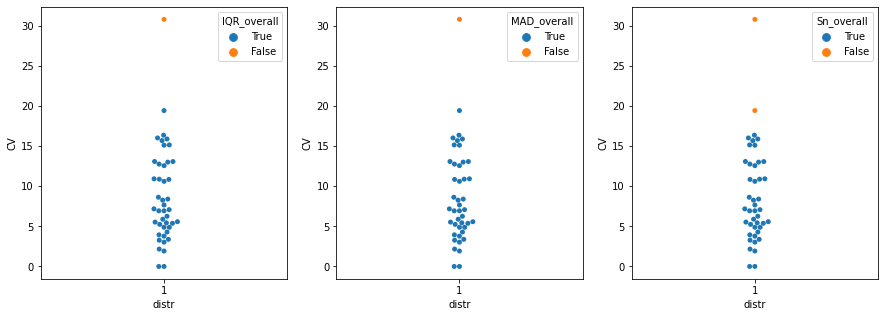

In [1025]:
calc_outliers_overall(NC_tri_CV, 'CV')
plot_outliers_overall(NC_tri_CV, 'CV')

In [1049]:
NC_tri_CV[NC_tri_CV.Sn_overall == True].CV.describe()

count    42.000000
mean      8.042249
std       4.654450
min       0.000000
25%       4.880703
50%       7.004077
75%      12.148908
max      16.355859
Name: CV, dtype: float64

In [1026]:
CVs = []
for lst in [PC_tri_CV.CV.values.tolist(), inh_25_tri_CV.CV.values.tolist(), inh_10_tri_CV.CV.values.tolist()]:
    CVs.extend(lst)
    
len(CVs)

180

/Users/dueva1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AttributeError: 'list' object has no attribute 'shape'

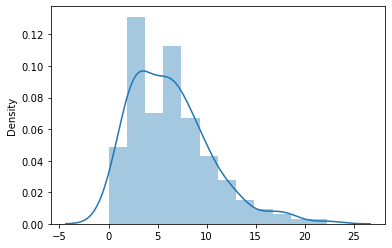

In [1027]:
sns.distplot(CVs);
qqplot(CVs, line='s');
pyplot.show()

In [1043]:
CVs_fr = pd.DataFrame(CVs)

In [1044]:
CVs_fr.rename(columns = {0:'CV'}, inplace = True)

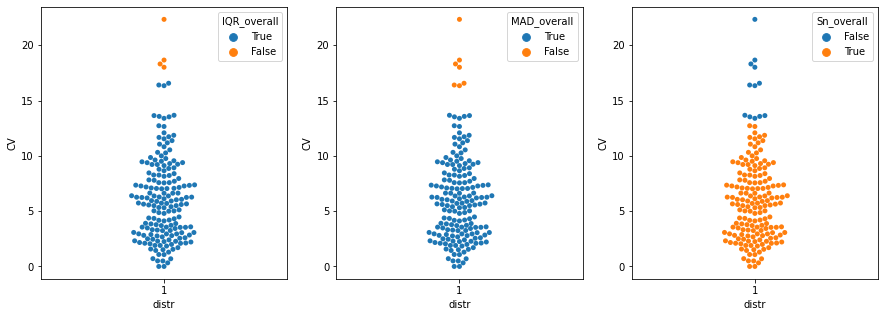

In [1045]:
calc_outliers_overall(CVs_fr, 'CV')
plot_outliers_overall(CVs_fr, 'CV')

In [1046]:
CVs_fr[CVs_fr.Sn_overall == True].CV.describe()

count    164.000000
mean       5.575306
std        3.105812
min        0.000000
25%        2.942037
50%        5.579004
75%        7.724310
max       12.720343
Name: CV, dtype: float64